### Import relevant packages

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage.filters as filter
import time
import os
import os.path
import commands
import pickle, gzip
from scipy import interpolate
import optparse as op
from matplotlib import rc
import matplotlib
import glob

### Define confidence functions

In [7]:
# Module for confidence calculations
class confidence(object):
    def __init__(self, counts):
        # Sort in descending order in frequency
        self.counts_sorted = np.sort(counts.flatten())[::-1]
        # Get a normalized cumulative distribution from the mode
        self.norm_cumsum_counts_sorted = np.cumsum(self.counts_sorted) / np.sum(counts)
        # Set interpolations between heights, bins and levels
        self._set_interp()
    def _set_interp(self):
        self._length = len(self.counts_sorted)
        # height from index
        self._height_from_idx = interpolate.interp1d(np.arange(self._length), self.counts_sorted, bounds_error=False, fill_value=0.)
        # index from height
        self._idx_from_height = interpolate.interp1d(self.counts_sorted[::-1], np.arange(self._length)[::-1], bounds_error=False, fill_value=self._length)
        # level from index
        self._level_from_idx = interpolate.interp1d(np.arange(self._length), self.norm_cumsum_counts_sorted, bounds_error=False, fill_value=1.)
        # index from level
        self._idx_from_level = interpolate.interp1d(self.norm_cumsum_counts_sorted, np.arange(self._length), bounds_error=False, fill_value=self._length)
    def level_from_height(self, height):
        return self._level_from_idx(self._idx_from_height(height))
    def height_from_level(self, level):
        return self._height_from_idx(self._idx_from_level(level))

# gaussian filter with 1-sigma softening
def gf(P):
    return filter.gaussian_filter(P, sigma=1.0)

# compute 1-sigma confidence intervals in 1D
def calc_cred_intervals_in_1d(P, x):

    # find the value of P corresponding to 50% and 9% confidence heights
    conf = confidence(P)
    P_s1 = conf.height_from_level(0.5)
    P_s2 = conf.height_from_level(0.9)

    # calculation of condifence edges (values of x corresponding to the height s1 on the two sides)
    x_s1_l = min(x[np.where(P >= P_s1)[0]])
    x_s1_r = max(x[np.where(P >= P_s1)[0]])

    # calculation of condifence edges (values of x corresponding to the height s2 on the two sides)
    x_s2_l = min(x[np.where(P >= P_s2)[0]])
    x_s2_r = max(x[np.where(P >= P_s2)[0]])

    return P_s1, P_s2, x_s1_l, x_s1_r, x_s2_l, x_s2_r

def matched_filter_snr_module(filename):
    data = np.genfromtxt(filename, dtype=None, names=True, usecols=(0,1,2,3,4,5,6))
    var_names = [d[0] for d in data]
    stat_names = data.dtype.names
    matched_filter_snr = data[var_names.index('matched_filter_snr')][stat_names.index('median')+1]
    return matched_filter_snr

def sample_range(postloc):
    data = np.genfromtxt(postloc, names=True, dtype=None)
    params_list = ['m1','m2','distance']
    range_map = {'m1':[],'m2':[],'distance':[]}

    for param in params_list:
        range_map[param] = [min(data[param]),max(data[param])]

    return range_map

# IMRTGR Results

### Prior for computation of joint posteriors

In [8]:
# load the pickle file containing the interpolant of the prior in delta_Mf/Mf, delta_af/a
prior_file = '/home/abhirup/Documents/Work/testGR_IR/runs/systematics_error_characterisation/prior_bbh_average_fits_precessing_alignedspinzprior_compmassmin_10_compmassmax_200_nbins_201_dMfbyMf_lim_2_dafbyaf_lim_2'
f = gzip.open(prior_file+".pklz",'rb')
P_dMfbyMf_dchifbychif_pr_interp_obj = pickle.load(f)

## Computing joint posteriors

### IMRPhenomPv2 results

In [9]:
case_list = ['imrppv2_injection_o1o2_noise','imrppv2_injection_psdmodel_zeronoise']

data not found


/home/abhirup/src/pycbc_new/lib/python2.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in divide


data not found
data not found


/home/abhirup/src/pycbc_new/lib/python2.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in multiply


data not found
data not found
data not found
data not found
data not found


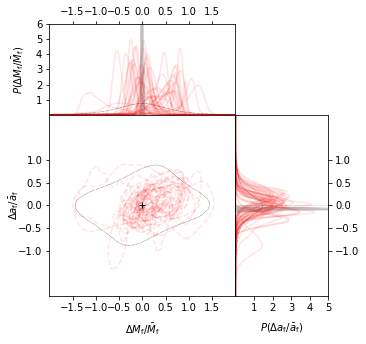

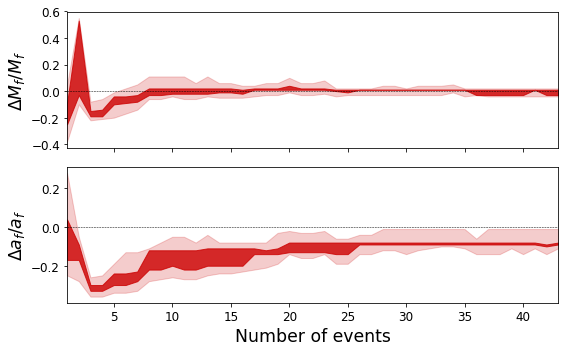

data not found
data not found
data not found
data not found
data not found
data not found


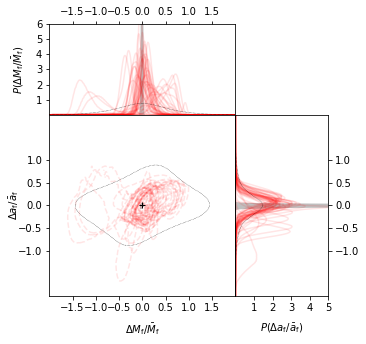

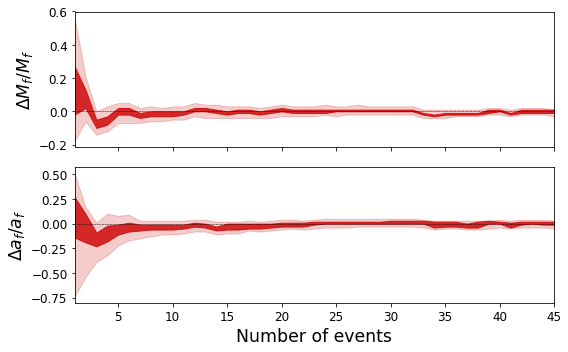

In [10]:
for case in case_list:
    
    post_loc_root = '/home/abhirup/Documents/Work/testGR_IR/runs/systematics_error_characterisation/new_runs/%s'%case
    post_loc_list = glob.glob(post_loc_root + '/*')

    out_dir = post_loc_root + '/imrtgr_results_joint'
    os.system('mkdir -p %s/data %s/img'%(out_dir, out_dir))
    N_bins = 401
    
    # initialize variables
    P_dMfbyMf_dchifbychif_joint = np.ones((N_bins, N_bins))

    left1_v1_joint_list = []
    left1_v2_joint_list = []
    left2_v1_joint_list = []
    left2_v2_joint_list = []
    right1_v1_joint_list = []
    right1_v2_joint_list = []
    right2_v1_joint_list = []
    right2_v2_joint_list = []

    p = plt.figure(figsize=(5,5))
    ax1 = plt.subplot2grid((3,3), (0,0), colspan=2)
    ax2 = plt.subplot2grid((3,3), (1,2), rowspan=2)
    ax3 = plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)

    for (idx, post_loc) in enumerate(post_loc_list):
       
        try:
            
            P_dMfbyMf_dchifbychif = np.loadtxt('%s/imrtgr_results/data/P_dMfbyMf_dchifbychif.dat.gz'%post_loc)
            dMfbyMf_vec = np.loadtxt('%s/imrtgr_results/data/dMfbyMf_vec.dat.gz'%post_loc)
            dchifbychif_vec = np.loadtxt('%s/imrtgr_results/data/dchifbychif_vec.dat.gz'%post_loc)
            P_dMfbyMf_dchifbychif_interp_obj = scipy.interpolate.interp2d(dMfbyMf_vec, dchifbychif_vec, P_dMfbyMf_dchifbychif, fill_value=0., bounds_error=False)	

            # normalize the 2D posterior 
            dx = np.mean(np.diff(dMfbyMf_vec))
            dy = np.mean(np.diff(dchifbychif_vec))
            P_dMfbyMf_dchifbychif /= np.sum(P_dMfbyMf_dchifbychif) * dx * dy

            # compute the credible regions of this posterior
            conf_v1v2 = confidence(P_dMfbyMf_dchifbychif)
            s1_v1v2 = conf_v1v2.height_from_level(0.5)
            s2_v1v2 = conf_v1v2.height_from_level(0.9)

            # compute marginalized 1D posterior 
            P_dMfbyMf = np.sum(P_dMfbyMf_dchifbychif, axis=0) * dy
            P_dchifbychif = np.sum(P_dMfbyMf_dchifbychif, axis=1) * dx
            P_dMfbyMf /= np.sum(P_dMfbyMf) * dx
            P_dchifbychif /= np.sum(P_dchifbychif) * dy

            # calcualte the credible levels and intervals in the marginalized 1d posteriors (this event)
            s1_v1, s2_v1, left1_v1, right1_v1, left2_v1, right2_v1 = calc_cred_intervals_in_1d(P_dMfbyMf, dMfbyMf_vec)
            s1_v2, s2_v2, left1_v2, right1_v2, left2_v2, right2_v2 = calc_cred_intervals_in_1d(P_dchifbychif, dchifbychif_vec)

            # plot the posteriors of individual events
            ax1.plot(dMfbyMf_vec, P_dMfbyMf, color='r', alpha=0.1)
            ax2.plot(P_dchifbychif, dchifbychif_vec, color='r', alpha=0.1)
            ax3.contour(dMfbyMf_vec,dchifbychif_vec, gf(P_dMfbyMf_dchifbychif), levels=(s2_v1v2,), colors='r', linestyles='dashed', alpha=0.1)

            # evaluate the prior interpolant
            P_dMfbyMf_dchifbychif_pr = P_dMfbyMf_dchifbychif_pr_interp_obj(dMfbyMf_vec, dchifbychif_vec)
            P_dMfbyMf_dchifbychif_pr /= np.sum(P_dMfbyMf_dchifbychif_pr) * dx * dy

            # removing nans
            P_dMfbyMf_dchifbychif[np.isnan(P_dMfbyMf_dchifbychif)] = 0.
            P_dMfbyMf_dchifbychif[np.isinf(P_dMfbyMf_dchifbychif)] = 0.

            # replace all zeros in the posterior vector by a small number.
            # This is to avoid multiplication by zeros while combining the posteiror
            zidx = np.where(P_dMfbyMf_dchifbychif == 0.)
            P_dMfbyMf_dchifbychif[zidx] = 1e-16

            if idx >= 1:

                P_dMfbyMf_dchifbychif_joint *= P_dMfbyMf_dchifbychif/P_dMfbyMf_dchifbychif_pr

                # removing nans and inf, normalizing the joint posterior 
                P_dMfbyMf_dchifbychif_joint[np.isnan(P_dMfbyMf_dchifbychif_joint)] = 0.
                P_dMfbyMf_dchifbychif_joint[np.isinf(P_dMfbyMf_dchifbychif_joint)] = 0.
                P_dMfbyMf_dchifbychif_joint /= np.sum(P_dMfbyMf_dchifbychif_joint) * dx * dy

                # compute the credible level of the GR value from the combined posteriors
                conf_v1v2_joint = confidence(P_dMfbyMf_dchifbychif_joint)
                s1_v1v2_joint = conf_v1v2_joint.height_from_level(0.5)
                s2_v1v2_joint = conf_v1v2_joint.height_from_level(0.9)

                # Marginalization to one-dimensional joint_posteriors
                P_dMfbyMf_joint = np.sum(P_dMfbyMf_dchifbychif_joint, axis=0) * dy
                P_dchifbychif_joint = np.sum(P_dMfbyMf_dchifbychif_joint, axis=1) * dx

                # normalisation of individual posteriors
                P_dMfbyMf_joint /= np.sum(P_dMfbyMf_joint) * dx
                P_dchifbychif_joint /= np.sum(P_dchifbychif_joint) * dy

                # calcualte the credible levels and intervals in the marginalized 1d posteriors (joint)
                s1_v1_joint, s2_v1_joint, left1_v1_joint, right1_v1_joint, left2_v1_joint, right2_v1_joint = calc_cred_intervals_in_1d(P_dMfbyMf_joint, dMfbyMf_vec)
                s1_v2_joint, s2_v2_joint, left1_v2_joint, right1_v2_joint, left2_v2_joint, right2_v2_joint = calc_cred_intervals_in_1d(P_dchifbychif_joint, dchifbychif_vec)

                # append the confidence intervals for plotting (joint posteriors) 
                left1_v1_joint_list = np.append(left1_v1_joint_list, left1_v1_joint)
                right1_v1_joint_list = np.append(right1_v1_joint_list, right1_v1_joint)
                left2_v1_joint_list = np.append(left2_v1_joint_list, left2_v1_joint)
                right2_v1_joint_list = np.append(right2_v1_joint_list, right2_v1_joint)
                left1_v2_joint_list = np.append(left1_v2_joint_list, left1_v2_joint)
                right1_v2_joint_list = np.append(right1_v2_joint_list, right1_v2_joint)
                left2_v2_joint_list = np.append(left2_v2_joint_list, left2_v2_joint)
                right2_v2_joint_list = np.append(right2_v2_joint_list, right2_v2_joint)

                # calculate the GR percentile from combined posterior  
                gr_height_joint = P_dMfbyMf_dchifbychif_joint[np.argmin(abs(dMfbyMf_vec)), np.argmin(abs(dchifbychif_vec))]
                gr_credib_level_joint = conf_v1v2_joint.level_from_height(gr_height_joint)

        except IOError:
            print 'data not found'
                
                
    ################################################## 
    # compute final results from combined posteriors # 
    ##################################################

    # Marginalization to one-dimensional prior distributions 
    P_dMfbyMf_pr = np.sum(P_dMfbyMf_dchifbychif_pr, axis=0) * dy
    P_dchifbychif_pr = np.sum(P_dMfbyMf_dchifbychif_pr, axis=1) * dx

    # normalisation of prior distributions 
    P_dMfbyMf_pr /= np.sum(P_dMfbyMf_pr) * dx
    P_dchifbychif_pr /= np.sum(P_dchifbychif_pr) * dy

    # Calculation of credible levels in the 2D prior 
    conf_v1v2_pr = confidence(P_dMfbyMf_dchifbychif_pr)
    s1_v1v2_pr = conf_v1v2_pr.height_from_level(0.5)
    s2_v1v2_pr = conf_v1v2_pr.height_from_level(0.9)

    # save the combined posterior data 
    np.savetxt(out_dir+'/data/dMfbyMf_vec_joint.dat.gz', dMfbyMf_vec)
    np.savetxt(out_dir+'/data/dchifbychif_vec_joint.dat.gz', dchifbychif_vec)
    np.savetxt(out_dir+'/data/P_dMfbyMf_dchifbychi_joint.dat.gz', P_dMfbyMf_dchifbychif_joint)
    np.savetxt(out_dir+'/data/P_dMfbyMf_joint.dat.gz', P_dMfbyMf_joint)
    np.savetxt(out_dir+'/data/P_dchifbychif_joint.dat.gz', P_dchifbychif_joint)

    # make plots 
    ax1.fill(dMfbyMf_vec, P_dMfbyMf_joint, 'gray', alpha=0.5)
    ax1.plot(dMfbyMf_vec, P_dMfbyMf_pr, 'k',  lw=0.5, ls=':')
    ax2.fill(P_dchifbychif_joint, dchifbychif_vec, 'gray', alpha=0.5)
    ax2.plot(P_dchifbychif_pr, dchifbychif_vec, 'k', lw=0.5, ls=':')
    ax3.contourf(dMfbyMf_vec,dchifbychif_vec,gf(P_dMfbyMf_dchifbychif_joint), levels=(s2_v1v2_joint, np.inf), linewidths=(1.5,0.5), colors='gray', linestyles=('--'), alpha=0.5)
    ax3.contour(dMfbyMf_vec,dchifbychif_vec,gf(P_dMfbyMf_dchifbychif_pr), levels=(s2_v1v2_pr,), linewidths=(0.5,0.5), colors='k', linestyles=(':'))
    ax3.plot(0, 0, 'k+', mew=1)
    # axis limits 
    ax1.set_xlim(-2,2)
    ax1.set_ylim(0,6)
    ax2.set_ylim(-2,2)
    ax2.set_xlim(0,5)
    ax3.set_xlim(-2,2)
    ax3.set_ylim(-2,2)
    # tick labels 
    ax1.xaxis.tick_top()
    ax2.yaxis.tick_right()
    ax1.set_xticks(np.arange(-1.5, 1.51, 0.5))
    ax1.set_yticks(np.arange(1, 7, 1.))
    ax2.set_xticks(np.arange(1, 6, 1.))
    ax2.set_yticks(np.arange(-1, 1.1, 0.5))
    ax3.set_xticks(np.arange(-1.5, 1.51, 0.5))
    ax3.set_yticks(np.arange(-1, 1.1, 0.5))
    # axis labels and legends 
    ax1.legend(bbox_to_anchor=(1.05, 1.1), loc=2, borderaxespad=0.,frameon=False)
    ax2.set_xlabel(r'$P(\Delta a_{\mathrm{f}}/ \bar{a}_{\mathrm{f}})$', labelpad=8)
    ax1.set_ylabel(r'$P(\Delta M_{\mathrm{f}}/ \bar{M}_{\mathrm{f}})$', labelpad=10)
    ax3.set_xlabel(r'$\Delta M_{\mathrm{f}}/ \bar{M}_{\mathrm{f}}$', labelpad=8)
    ax3.set_ylabel(r'$\Delta a_{\mathrm{f}}/ \bar{a}_{\mathrm{f}}$', labelpad=-3)
    plt.subplots_adjust(wspace=0., hspace=0.)
    # save plots 
    plt.savefig(out_dir+'/img/dMfbyMf_dchifbychi_joint.pdf', dpi=150)

    plt.figure(figsize=(8,5))
    ax = plt.subplot(211)
    ax.set_xticklabels([])
    plt.fill_between(1+np.arange(len(left1_v1_joint_list)), left1_v1_joint_list, right1_v1_joint_list, color='#cc0000', alpha=0.8) #, label='68\%')
    plt.fill_between(1+np.arange(len(left2_v1_joint_list)), left2_v1_joint_list, right2_v1_joint_list, color='#cc0000', alpha=0.2) #, label='95\%')
    plt.axhline(y=0., color='k', ls='--', lw=0.5)
    #plt.ylim(-0.4,0.4)
    plt.xlim([1, len(left1_v1_joint_list)])
    plt.ylabel('$\Delta M_f/M_f$', fontsize='xx-large')
    plt.yticks(fontsize = 'large')
    plt.subplot(212)
    plt.fill_between(1+np.arange(len(left1_v2_joint_list)), left1_v2_joint_list, right1_v2_joint_list, color='#cc0000', alpha=0.8) #, label='68\%')
    plt.fill_between(1+np.arange(len(left2_v2_joint_list)), left2_v2_joint_list, right2_v2_joint_list, color='#cc0000', alpha=0.2) #, label='95\%')
    plt.axhline(y=0., color='k', ls='--', lw=0.5)
    #plt.ylim(-0.4,0.4)
    plt.xlim([1, len(left1_v2_joint_list)])
    plt.xticks(fontsize = 'large')
    plt.yticks(fontsize = 'large')
    plt.xlabel('Number of events', fontsize='xx-large')
    plt.ylabel('$\Delta a_f/a_f$', fontsize='xx-large')
    plt.tight_layout()
    plt.savefig(out_dir+'/img/dMfbyMf_dchifbychif_jointposterior_vs_events_GR_injections.pdf', dpi=300)

    plt.show()   

### NR Injections

In [11]:
case_list = ['sxs_injection_o1o2_noise','sxs_injection_psdmodel_zeronoise']

data not found
data not found


/home/abhirup/src/pycbc_new/lib/python2.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in divide


data not found
data not found
data not found
data not found
data not found


/home/abhirup/src/pycbc_new/lib/python2.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in multiply


data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not f

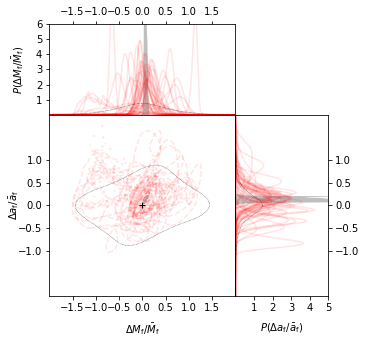

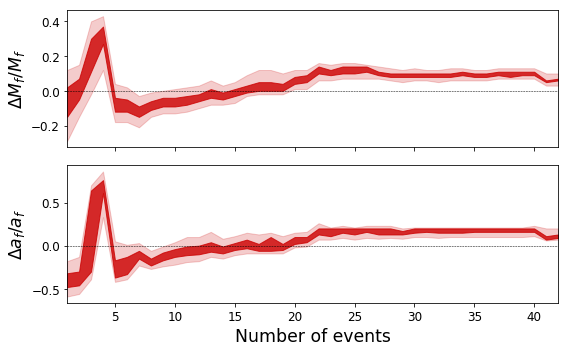

data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not found
data not f

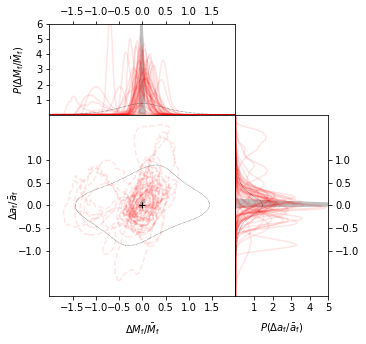

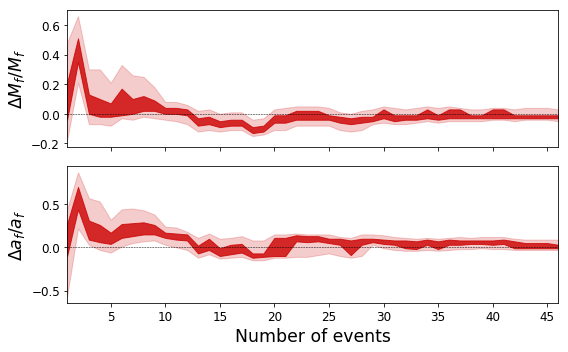

In [12]:
for case in case_list:
    
    post_loc_root = '/home/abhirup/Documents/Work/testGR_IR/runs/systematics_error_characterisation/new_runs/%s'%case
    post_loc_list = glob.glob(post_loc_root + '/*')

    out_dir = post_loc_root + '/imrtgr_results_joint'
    os.system('mkdir -p %s/data %s/img'%(out_dir, out_dir))
    N_bins = 401
    
    # initialize variables
    P_dMfbyMf_dchifbychif_joint = np.ones((N_bins, N_bins))

    left1_v1_joint_list = []
    left1_v2_joint_list = []
    left2_v1_joint_list = []
    left2_v2_joint_list = []
    right1_v1_joint_list = []
    right1_v2_joint_list = []
    right2_v1_joint_list = []
    right2_v2_joint_list = []

    p = plt.figure(figsize=(5,5))
    ax1 = plt.subplot2grid((3,3), (0,0), colspan=2)
    ax2 = plt.subplot2grid((3,3), (1,2), rowspan=2)
    ax3 = plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)

    for (idx, post_loc) in enumerate(post_loc_list):
       
        try:
            
            P_dMfbyMf_dchifbychif = np.loadtxt('%s/imrtgr_results/data/P_dMfbyMf_dchifbychif.dat.gz'%post_loc)
            dMfbyMf_vec = np.loadtxt('%s/imrtgr_results/data/dMfbyMf_vec.dat.gz'%post_loc)
            dchifbychif_vec = np.loadtxt('%s/imrtgr_results/data/dchifbychif_vec.dat.gz'%post_loc)
            P_dMfbyMf_dchifbychif_interp_obj = scipy.interpolate.interp2d(dMfbyMf_vec, dchifbychif_vec, P_dMfbyMf_dchifbychif, fill_value=0., bounds_error=False)	

            # normalize the 2D posterior 
            dx = np.mean(np.diff(dMfbyMf_vec))
            dy = np.mean(np.diff(dchifbychif_vec))
            P_dMfbyMf_dchifbychif /= np.sum(P_dMfbyMf_dchifbychif) * dx * dy

            # compute the credible regions of this posterior
            conf_v1v2 = confidence(P_dMfbyMf_dchifbychif)
            s1_v1v2 = conf_v1v2.height_from_level(0.5)
            s2_v1v2 = conf_v1v2.height_from_level(0.9)

            # compute marginalized 1D posterior 
            P_dMfbyMf = np.sum(P_dMfbyMf_dchifbychif, axis=0) * dy
            P_dchifbychif = np.sum(P_dMfbyMf_dchifbychif, axis=1) * dx
            P_dMfbyMf /= np.sum(P_dMfbyMf) * dx
            P_dchifbychif /= np.sum(P_dchifbychif) * dy

            # calcualte the credible levels and intervals in the marginalized 1d posteriors (this event)
            s1_v1, s2_v1, left1_v1, right1_v1, left2_v1, right2_v1 = calc_cred_intervals_in_1d(P_dMfbyMf, dMfbyMf_vec)
            s1_v2, s2_v2, left1_v2, right1_v2, left2_v2, right2_v2 = calc_cred_intervals_in_1d(P_dchifbychif, dchifbychif_vec)

            # plot the posteriors of individual events
            ax1.plot(dMfbyMf_vec, P_dMfbyMf, color='r', alpha=0.1)
            ax2.plot(P_dchifbychif, dchifbychif_vec, color='r', alpha=0.1)
            ax3.contour(dMfbyMf_vec,dchifbychif_vec, gf(P_dMfbyMf_dchifbychif), levels=(s2_v1v2,), colors='r', linestyles='dashed', alpha=0.1)

            # evaluate the prior interpolant
            P_dMfbyMf_dchifbychif_pr = P_dMfbyMf_dchifbychif_pr_interp_obj(dMfbyMf_vec, dchifbychif_vec)
            P_dMfbyMf_dchifbychif_pr /= np.sum(P_dMfbyMf_dchifbychif_pr) * dx * dy

            # removing nans
            P_dMfbyMf_dchifbychif[np.isnan(P_dMfbyMf_dchifbychif)] = 0.
            P_dMfbyMf_dchifbychif[np.isinf(P_dMfbyMf_dchifbychif)] = 0.

            # replace all zeros in the posterior vector by a small number.
            # This is to avoid multiplication by zeros while combining the posteiror
            zidx = np.where(P_dMfbyMf_dchifbychif == 0.)
            P_dMfbyMf_dchifbychif[zidx] = 1e-16

            if idx >= 1:

                P_dMfbyMf_dchifbychif_joint *= P_dMfbyMf_dchifbychif/P_dMfbyMf_dchifbychif_pr

                # removing nans and inf, normalizing the joint posterior 
                P_dMfbyMf_dchifbychif_joint[np.isnan(P_dMfbyMf_dchifbychif_joint)] = 0.
                P_dMfbyMf_dchifbychif_joint[np.isinf(P_dMfbyMf_dchifbychif_joint)] = 0.
                P_dMfbyMf_dchifbychif_joint /= np.sum(P_dMfbyMf_dchifbychif_joint) * dx * dy

                # compute the credible level of the GR value from the combined posteriors
                conf_v1v2_joint = confidence(P_dMfbyMf_dchifbychif_joint)
                s1_v1v2_joint = conf_v1v2_joint.height_from_level(0.5)
                s2_v1v2_joint = conf_v1v2_joint.height_from_level(0.9)

                # Marginalization to one-dimensional joint_posteriors
                P_dMfbyMf_joint = np.sum(P_dMfbyMf_dchifbychif_joint, axis=0) * dy
                P_dchifbychif_joint = np.sum(P_dMfbyMf_dchifbychif_joint, axis=1) * dx

                # normalisation of individual posteriors
                P_dMfbyMf_joint /= np.sum(P_dMfbyMf_joint) * dx
                P_dchifbychif_joint /= np.sum(P_dchifbychif_joint) * dy

                # calcualte the credible levels and intervals in the marginalized 1d posteriors (joint)
                s1_v1_joint, s2_v1_joint, left1_v1_joint, right1_v1_joint, left2_v1_joint, right2_v1_joint = calc_cred_intervals_in_1d(P_dMfbyMf_joint, dMfbyMf_vec)
                s1_v2_joint, s2_v2_joint, left1_v2_joint, right1_v2_joint, left2_v2_joint, right2_v2_joint = calc_cred_intervals_in_1d(P_dchifbychif_joint, dchifbychif_vec)

                # append the confidence intervals for plotting (joint posteriors) 
                left1_v1_joint_list = np.append(left1_v1_joint_list, left1_v1_joint)
                right1_v1_joint_list = np.append(right1_v1_joint_list, right1_v1_joint)
                left2_v1_joint_list = np.append(left2_v1_joint_list, left2_v1_joint)
                right2_v1_joint_list = np.append(right2_v1_joint_list, right2_v1_joint)
                left1_v2_joint_list = np.append(left1_v2_joint_list, left1_v2_joint)
                right1_v2_joint_list = np.append(right1_v2_joint_list, right1_v2_joint)
                left2_v2_joint_list = np.append(left2_v2_joint_list, left2_v2_joint)
                right2_v2_joint_list = np.append(right2_v2_joint_list, right2_v2_joint)

                # calculate the GR percentile from combined posterior  
                gr_height_joint = P_dMfbyMf_dchifbychif_joint[np.argmin(abs(dMfbyMf_vec)), np.argmin(abs(dchifbychif_vec))]
                gr_credib_level_joint = conf_v1v2_joint.level_from_height(gr_height_joint)

        except IOError:
            print 'data not found'
                
                
    ################################################## 
    # compute final results from combined posteriors # 
    ##################################################

    # Marginalization to one-dimensional prior distributions 
    P_dMfbyMf_pr = np.sum(P_dMfbyMf_dchifbychif_pr, axis=0) * dy
    P_dchifbychif_pr = np.sum(P_dMfbyMf_dchifbychif_pr, axis=1) * dx

    # normalisation of prior distributions 
    P_dMfbyMf_pr /= np.sum(P_dMfbyMf_pr) * dx
    P_dchifbychif_pr /= np.sum(P_dchifbychif_pr) * dy

    # Calculation of credible levels in the 2D prior 
    conf_v1v2_pr = confidence(P_dMfbyMf_dchifbychif_pr)
    s1_v1v2_pr = conf_v1v2_pr.height_from_level(0.5)
    s2_v1v2_pr = conf_v1v2_pr.height_from_level(0.9)

    # save the combined posterior data 
    np.savetxt(out_dir+'/data/dMfbyMf_vec_joint.dat.gz', dMfbyMf_vec)
    np.savetxt(out_dir+'/data/dchifbychif_vec_joint.dat.gz', dchifbychif_vec)
    np.savetxt(out_dir+'/data/P_dMfbyMf_dchifbychi_joint.dat.gz', P_dMfbyMf_dchifbychif_joint)
    np.savetxt(out_dir+'/data/P_dMfbyMf_joint.dat.gz', P_dMfbyMf_joint)
    np.savetxt(out_dir+'/data/P_dchifbychif_joint.dat.gz', P_dchifbychif_joint)

    # make plots 
    ax1.fill(dMfbyMf_vec, P_dMfbyMf_joint, 'gray', alpha=0.5)
    ax1.plot(dMfbyMf_vec, P_dMfbyMf_pr, 'k',  lw=0.5, ls=':')
    ax2.fill(P_dchifbychif_joint, dchifbychif_vec, 'gray', alpha=0.5)
    ax2.plot(P_dchifbychif_pr, dchifbychif_vec, 'k', lw=0.5, ls=':')
    ax3.contourf(dMfbyMf_vec,dchifbychif_vec,gf(P_dMfbyMf_dchifbychif_joint), levels=(s2_v1v2_joint, np.inf), linewidths=(1.5,0.5), colors='gray', linestyles=('--'), alpha=0.5)
    ax3.contour(dMfbyMf_vec,dchifbychif_vec,gf(P_dMfbyMf_dchifbychif_pr), levels=(s2_v1v2_pr,), linewidths=(0.5,0.5), colors='k', linestyles=(':'))
    ax3.plot(0, 0, 'k+', mew=1)
    # axis limits 
    ax1.set_xlim(-2,2)
    ax1.set_ylim(0,6)
    ax2.set_ylim(-2,2)
    ax2.set_xlim(0,5)
    ax3.set_xlim(-2,2)
    ax3.set_ylim(-2,2)
    # tick labels 
    ax1.xaxis.tick_top()
    ax2.yaxis.tick_right()
    ax1.set_xticks(np.arange(-1.5, 1.51, 0.5))
    ax1.set_yticks(np.arange(1, 7, 1.))
    ax2.set_xticks(np.arange(1, 6, 1.))
    ax2.set_yticks(np.arange(-1, 1.1, 0.5))
    ax3.set_xticks(np.arange(-1.5, 1.51, 0.5))
    ax3.set_yticks(np.arange(-1, 1.1, 0.5))
    # axis labels and legends 
    ax1.legend(bbox_to_anchor=(1.05, 1.1), loc=2, borderaxespad=0.,frameon=False)
    ax2.set_xlabel(r'$P(\Delta a_{\mathrm{f}}/ \bar{a}_{\mathrm{f}})$', labelpad=8)
    ax1.set_ylabel(r'$P(\Delta M_{\mathrm{f}}/ \bar{M}_{\mathrm{f}})$', labelpad=10)
    ax3.set_xlabel(r'$\Delta M_{\mathrm{f}}/ \bar{M}_{\mathrm{f}}$', labelpad=8)
    ax3.set_ylabel(r'$\Delta a_{\mathrm{f}}/ \bar{a}_{\mathrm{f}}$', labelpad=-3)
    plt.subplots_adjust(wspace=0., hspace=0.)
    # save plots 
    plt.savefig(out_dir+'/img/dMfbyMf_dchifbychi_joint.pdf', dpi=150)

    plt.figure(figsize=(8,5))
    ax = plt.subplot(211)
    ax.set_xticklabels([])
    plt.fill_between(1+np.arange(len(left1_v1_joint_list)), left1_v1_joint_list, right1_v1_joint_list, color='#cc0000', alpha=0.8) #, label='68\%')
    plt.fill_between(1+np.arange(len(left2_v1_joint_list)), left2_v1_joint_list, right2_v1_joint_list, color='#cc0000', alpha=0.2) #, label='95\%')
    plt.axhline(y=0., color='k', ls='--', lw=0.5)
    #plt.ylim(-0.4,0.4)
    plt.xlim([1, len(left1_v1_joint_list)])
    plt.ylabel('$\Delta M_f/M_f$', fontsize='xx-large')
    plt.yticks(fontsize = 'large')
    plt.subplot(212)
    plt.fill_between(1+np.arange(len(left1_v2_joint_list)), left1_v2_joint_list, right1_v2_joint_list, color='#cc0000', alpha=0.8) #, label='68\%')
    plt.fill_between(1+np.arange(len(left2_v2_joint_list)), left2_v2_joint_list, right2_v2_joint_list, color='#cc0000', alpha=0.2) #, label='95\%')
    plt.axhline(y=0., color='k', ls='--', lw=0.5)
    #plt.ylim(-0.4,0.4)
    plt.xlim([1, len(left1_v2_joint_list)])
    plt.xticks(fontsize = 'large')
    plt.yticks(fontsize = 'large')
    plt.xlabel('Number of events', fontsize='xx-large')
    plt.ylabel('$\Delta a_f/a_f$', fontsize='xx-large')
    plt.tight_layout()
    plt.savefig(out_dir+'/img/dMfbyMf_dchifbychif_jointposterior_vs_events_GR_injections.pdf', dpi=300)

    plt.show()   

# Frame outputs

## PSD Model: Zero-noise

In [6]:
import json
import numpy as np
import sys
sys.path.append('../src')
import standard_gwtransf as gw
import os
import pycbc
import pycbc.noise
import pycbc.psd
from pycbc.frame import query_and_read_frame
from pycbc.types import timeseries
from pycbc.psd import inverse_spectrum_truncation, interpolate
from pycbc.waveform import get_fd_waveform, get_td_waveform
import pycbc.filter.matchedfilter as mfilter
from pycbc import frame as Fr
import matplotlib.pyplot as plt
import scipy.signal
import glob

In [7]:
inj_data = np.genfromtxt('/home/abhirup/Documents/Work/testGR_IR/runs/systematics_error_characterisation/SXS_campaign.dat', names=True, dtype=None)   
color_map = ['r','k']

/home/abhirup/src/pycbc_new/lib/python2.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.


/home/abhirup/src/pycbc_new/lib/python2.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/home/abhirup/src/pycbc_new/local/lib/python2.7/site-packages/matplotlib/__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/abhirup/src/pycbc_new/local/lib/python2.7/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


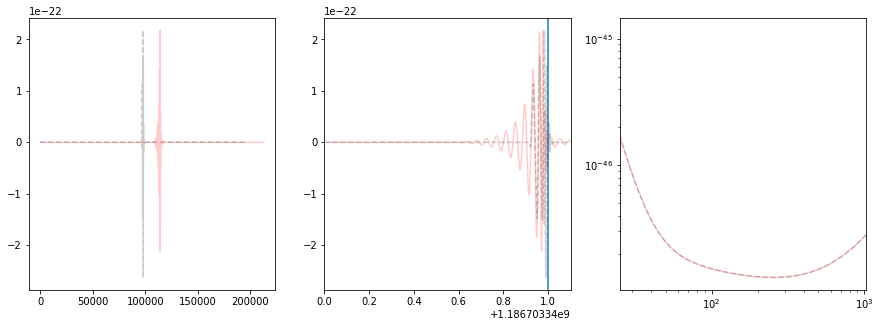

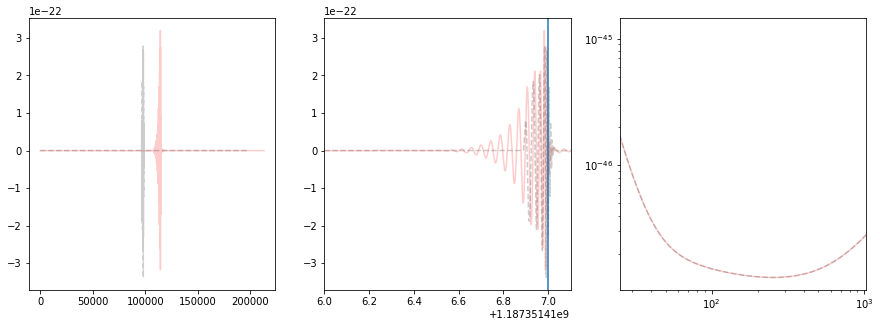

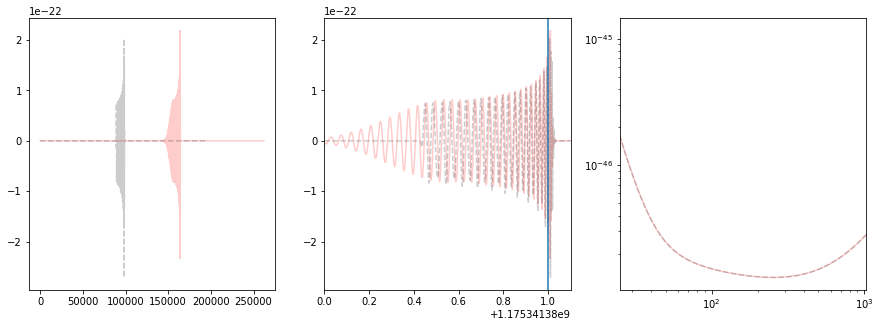

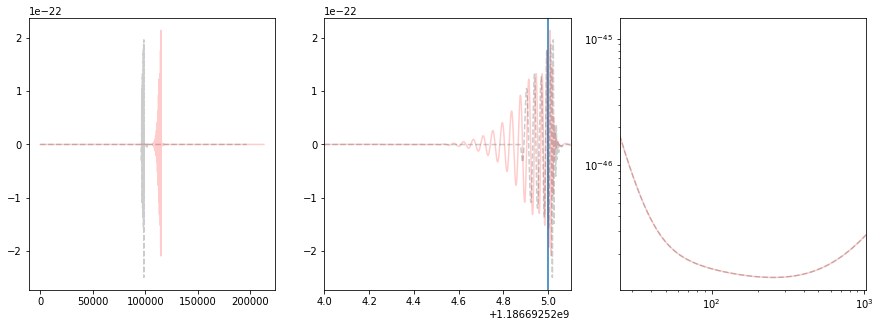

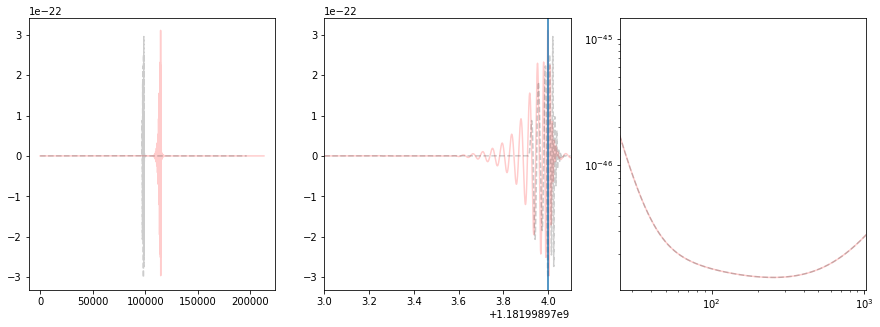

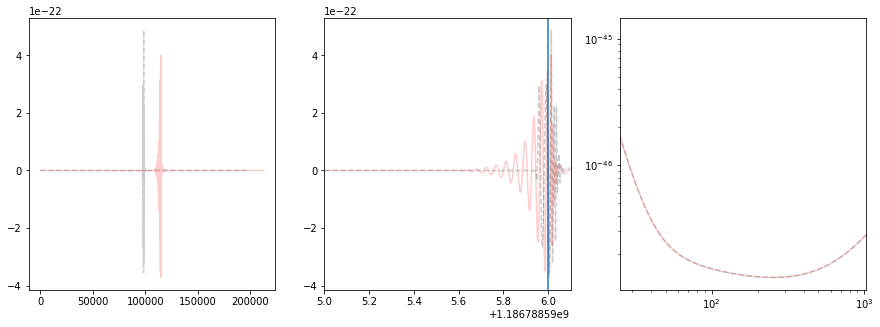

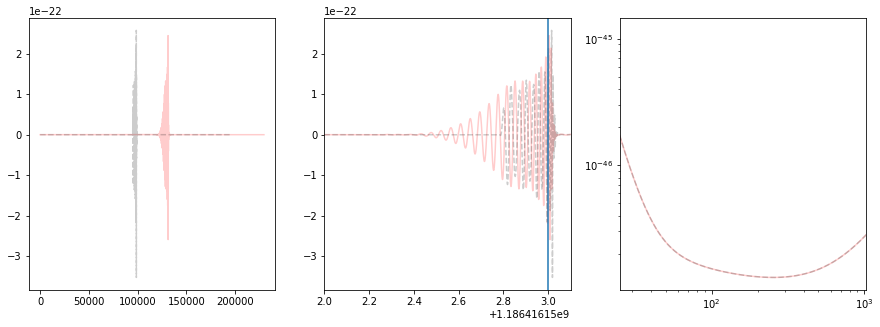

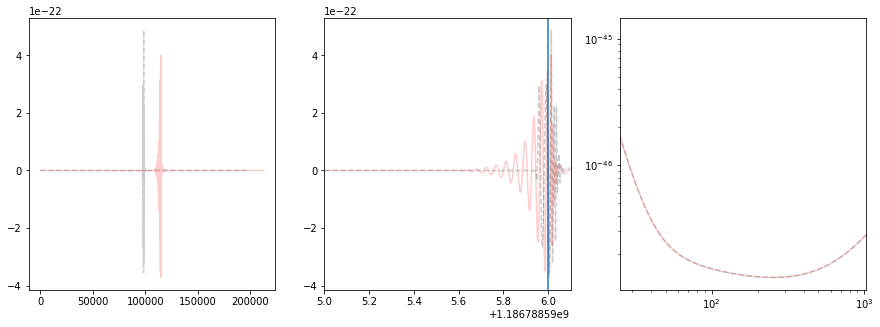

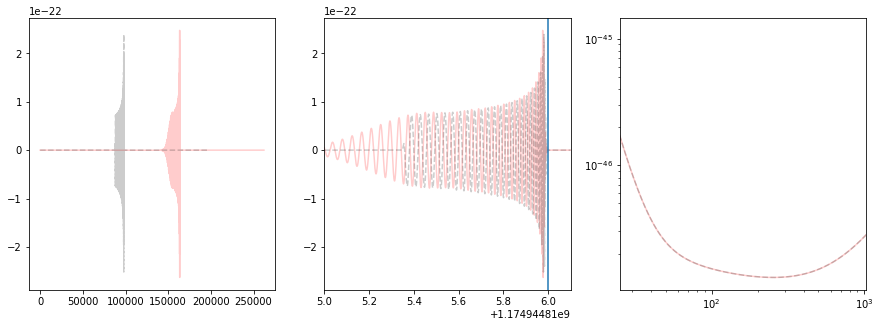

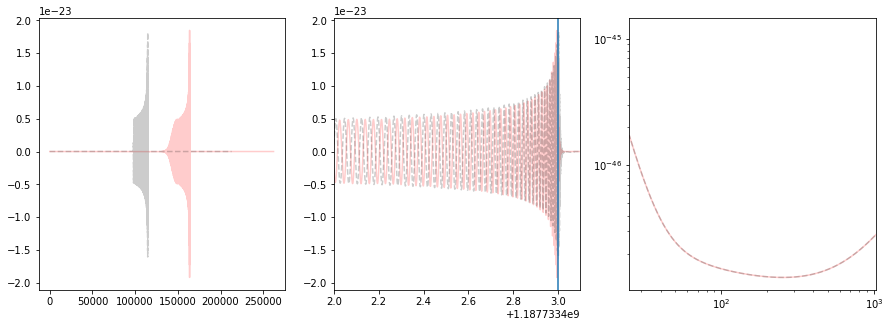

In [8]:
for idx in range(10):

    i = np.random.randint(100)
    gps_start_time = inj_data['gps_start_time'][i]
    gps_end_time = inj_data['gps_end_time'][i]
    geocentric_end_time = inj_data['geocentric_end_time'][i]
    tag = inj_data['tag'][i]
    
    h1_inj_ppv2 = glob.glob('/home/abhirup/Documents/Work/testGR_IR/runs/systematics_error_characterisation/imrppv2_injection_psdmodel_zeronoise/%s/IMR/%s_*_H1.txt'%(tag, tag))[0]
    h1_inj_ppv2 = np.genfromtxt(h1_inj_ppv2)
    h1_inj_sxs = glob.glob('/home/abhirup/Documents/Work/testGR_IR/runs/systematics_error_characterisation/sxs_injection_psdmodel_zeronoise/%s/IMR/%s_*_H1.txt'%(tag, tag))[0]
    h1_inj_sxs = np.genfromtxt(h1_inj_sxs)
    
    h1_hoft_hwinj_ppv2 = Fr.read_frame('/home/abhirup/Documents/Work/testGR_IR/runs/systematics_error_characterisation/imrppv2_injection_psdmodel_zeronoise/%s/IMR/H-H1HWINJ.gwf'%tag, 'H1:HWINJ_INJECTED', gps_start_time, gps_end_time)
    h1_hoft_hwinj_sxs = Fr.read_frame('/home/abhirup/Documents/Work/testGR_IR/runs/systematics_error_characterisation/sxs_injection_psdmodel_zeronoise/%s/IMR/H-H1HWINJ.gwf'%tag, 'H1:HWINJ_INJECTED', gps_start_time, gps_end_time)

    h1_freq_ppv2, h1_psd_ppv2 = np.genfromtxt('/home/abhirup/Documents/Work/testGR_IR/runs/systematics_error_characterisation/imrppv2_injection_psdmodel_zeronoise/%s/IMR/H1_psd.txt'%tag, unpack=True)
    h1_freq_sxs, h1_psd_sxs = np.genfromtxt('/home/abhirup/Documents/Work/testGR_IR/runs/systematics_error_characterisation/sxs_injection_psdmodel_zeronoise/%s/IMR/H1_psd.txt'%tag, unpack=True)
    
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.plot(h1_inj_ppv2, alpha=0.2, color='r')
    plt.plot(h1_inj_sxs, alpha=0.2, color='k', ls='dashed')
    
    plt.subplot(132)
    plt.plot(h1_hoft_hwinj_ppv2.sample_times, h1_hoft_hwinj_ppv2, alpha=0.2, color='r')
    plt.plot(h1_hoft_hwinj_sxs.sample_times, h1_hoft_hwinj_sxs, alpha=0.2, color='k', ls='dashed')
    plt.axvline(x=geocentric_end_time)
    plt.xlim([geocentric_end_time-1, geocentric_end_time+0.1])
    plt.hold(True)

    plt.subplot(133)
    plt.loglog(h1_freq_ppv2, h1_psd_ppv2,alpha=0.2, color='r')
    plt.loglog(h1_freq_sxs, h1_psd_sxs, alpha=0.2, color='k', ls='dashed')
    plt.xlim([25,1024])
    
    plt.show()

/home/abhirup/src/pycbc_new/lib/python2.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


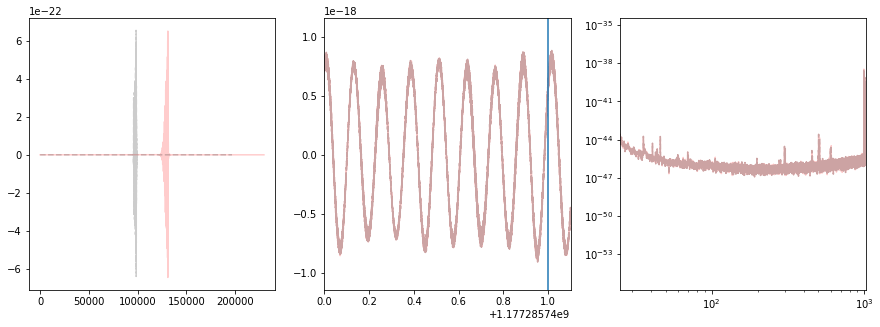

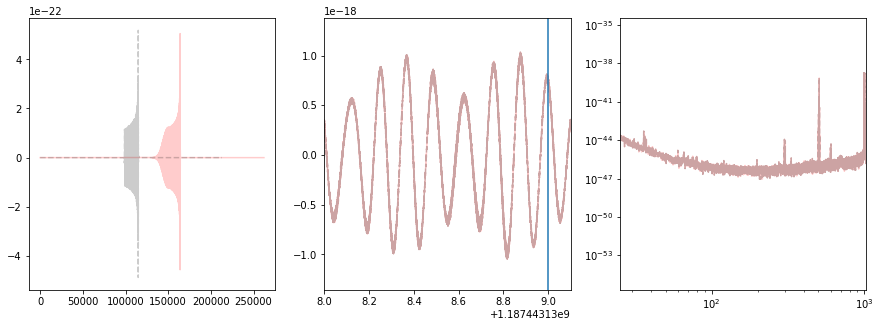

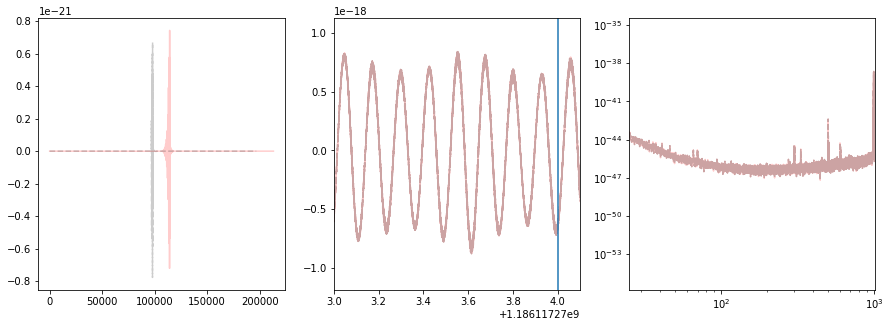

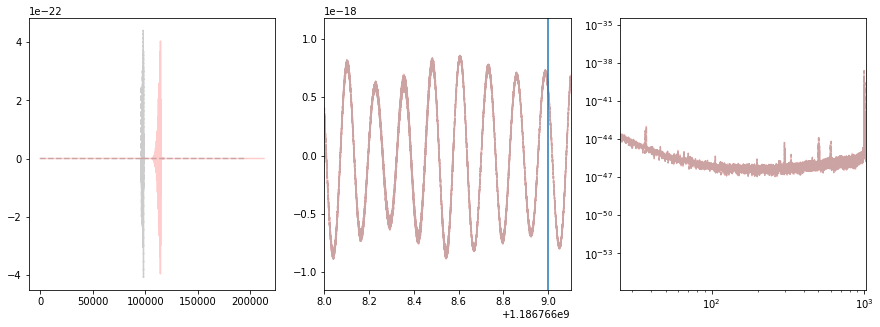

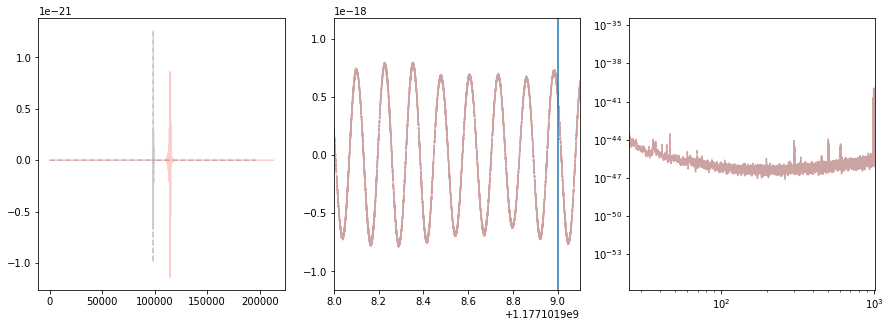

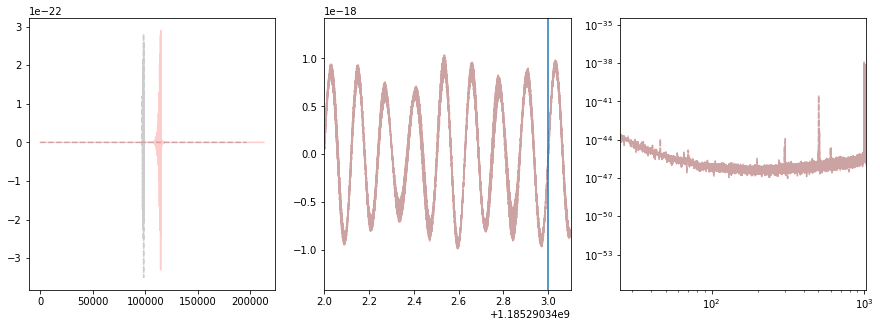

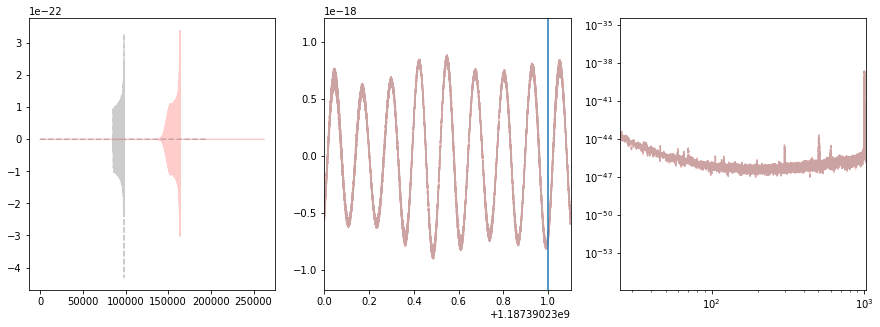

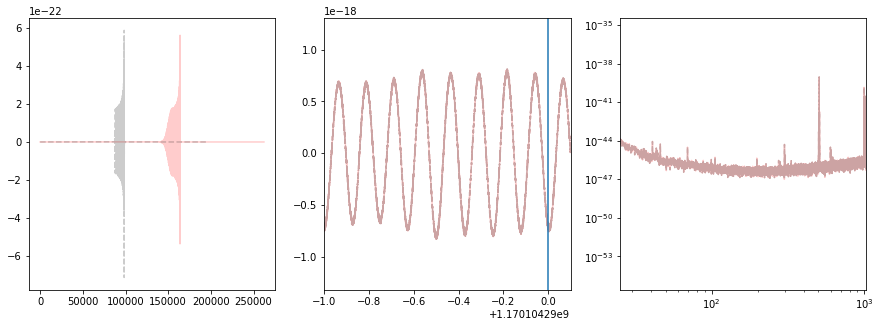

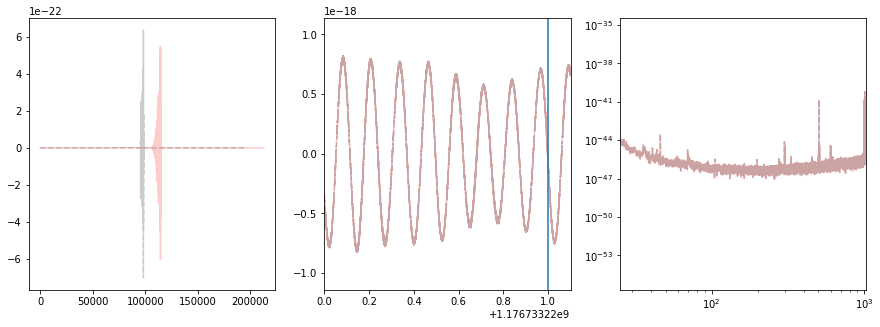

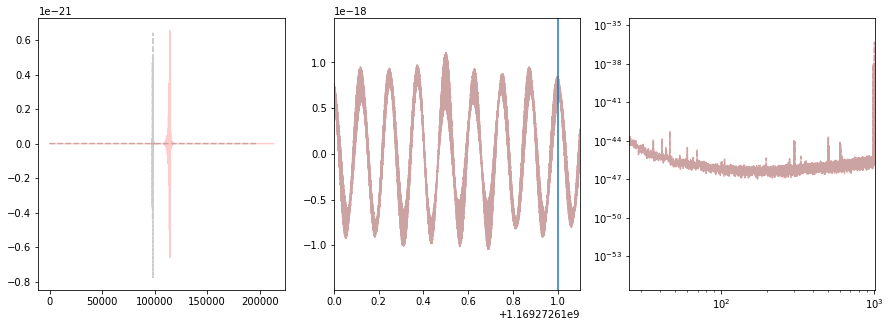

In [9]:
for idx in range(10):

    i = np.random.randint(100)
    gps_start_time = inj_data['gps_start_time'][i]
    gps_end_time = inj_data['gps_end_time'][i]
    geocentric_end_time = inj_data['geocentric_end_time'][i]
    tag = inj_data['tag'][i]

    h1_inj_ppv2 = glob.glob('/home/abhirup/Documents/Work/testGR_IR/runs/systematics_error_characterisation/imrppv2_injection_o1o2_noise/%s/IMR/%s_*_H1.txt'%(tag, tag))[0]
    h1_inj_ppv2 = np.genfromtxt(h1_inj_ppv2)
    h1_inj_sxs = glob.glob('/home/abhirup/Documents/Work/testGR_IR/runs/systematics_error_characterisation/sxs_injection_o1o2_noise/%s/IMR/%s_*_H1.txt'%(tag, tag))[0]
    h1_inj_sxs = np.genfromtxt(h1_inj_sxs)
    
    h1_hoft_hwinj_ppv2 = Fr.read_frame('/home/abhirup/Documents/Work/testGR_IR/runs/systematics_error_characterisation/imrppv2_injection_o1o2_noise/%s/IMR/H-H1HWINJ.gwf'%tag, 'H1:HWINJ_INJECTED', gps_start_time, gps_end_time)
    h1_hoft_hwinj_sxs = Fr.read_frame('/home/abhirup/Documents/Work/testGR_IR/runs/systematics_error_characterisation/sxs_injection_o1o2_noise/%s/IMR/H-H1HWINJ.gwf'%tag, 'H1:HWINJ_INJECTED', gps_start_time, gps_end_time)

    h1_freq_ppv2, h1_psd_ppv2 = np.genfromtxt('/home/abhirup/Documents/Work/testGR_IR/runs/systematics_error_characterisation/imrppv2_injection_o1o2_noise/%s/IMR/H1_psd.txt'%tag, unpack=True)
    h1_freq_sxs, h1_psd_sxs = np.genfromtxt('/home/abhirup/Documents/Work/testGR_IR/runs/systematics_error_characterisation/sxs_injection_o1o2_noise/%s/IMR/H1_psd.txt'%tag, unpack=True)
    
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.plot(h1_inj_ppv2, alpha=0.2, color='r')
    plt.plot(h1_inj_sxs, alpha=0.2, color='k', ls='dashed')
    
    plt.subplot(132)
    plt.plot(h1_hoft_hwinj_ppv2.sample_times, h1_hoft_hwinj_ppv2, alpha=0.2, color='r')
    plt.plot(h1_hoft_hwinj_sxs.sample_times, h1_hoft_hwinj_sxs, alpha=0.2, color='k', ls='dashed')
    plt.axvline(x=geocentric_end_time)
    plt.xlim([geocentric_end_time-1, geocentric_end_time+0.1])
    plt.hold(True)

    plt.subplot(133)
    plt.loglog(h1_freq_ppv2, h1_psd_ppv2,alpha=0.2, color='r')
    plt.loglog(h1_freq_sxs, h1_psd_sxs, alpha=0.2, color='k', ls='dashed')
    plt.xlim([25,1024])
    
    plt.show()